# Notebook to plot REMUS 600 data from Pioneer Array

In [1]:
!pip install git+https://github.com/seagrinch/ooilab.git
# %matplotlib widget
import ooilab
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.dates as dates

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/seagrinch/ooilab.git to /tmp/pip-req-build-8o_b_c0l
  Running command git clone -q https://github.com/seagrinch/ooilab.git /tmp/pip-req-build-8o_b_c0l
  Created wheel for ooilab: filename=ooilab-0.2-cp37-none-any.whl size=2579 sha256=9bcb82b79576b78186dc26efbad59ec7738de99579ae7d99c7774a62c5dea283
  Stored in directory: /tmp/pip-ephem-wheel-cache-1oc4qh1a/wheels/7f/c9/1d/60f91d31a29c5e03e8bc9dd7a58918a976a3f2ffe1ffcb3ea1
Successfully built ooilab


Go to https://ooinet.oceanobservatories.org/data_access/#CP05MOAS-A6264-03-CTDAVN000 and request data download  
--> will recieve email with a link for direct download or opendap link. The latter allows you to load data directly into python (see below)


Ideally we want to use the ooilab toolbox (https://github.com/seagrinch/ooilab, https://datalab.marine.rutgers.edu/2020/11/my-ooilab-python-toolbox/)where we don't need to request data through the data portal first to get the link. However, I get an error using it at the moment.

In [52]:
url1 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sryan@whoi.edu/20210322T140441502Z-CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data/catalog.html'
# url2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sryan@whoi.edu/20210323T013051722Z-CP05MOAS-A6264-03-CTDAVN000-recovered_host-ctdav_auv_data/catalog.html'
# flist = ooilab.get_filelist(url1)

In [53]:
# open all files available and load into xarray
ds = xr.open_mfdataset(flist).swap_dims({'obs': 'time'}).sortby('time')

# Separate missions

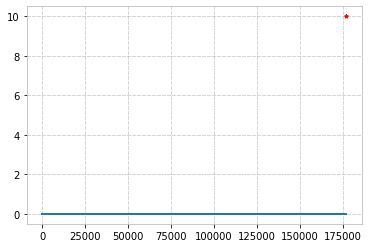

In [51]:
import matplotlib.dates as mdates
plt.plot(np.diff(mdates.date2num(ds['time'].values).astype(int)))
plt.xlim=[0,20000]

wo = np.where(np.diff(mdates.date2num(ds['time'].values).astype(int))>1)[0]
wo = np.append(wo,len(ds.time))
np.insert(wo,0,0)
plt.plot(np.asarray(wo),np.ones(len(wo))*10,marker='*',color='r')

We can see that there are multiple deployments. If we zoom in we see that one deployment consists of multiple profiles.

In [93]:
# get mission numbers
mission = np.unique(ds.deployment)
deployments = {}
for n,i in zip(mission,range(len(mission))):
    wo = np.where(ds.deployment==n)[0]
    deployments[i] = ds.isel(time=slice(wo[0],wo[-1]))

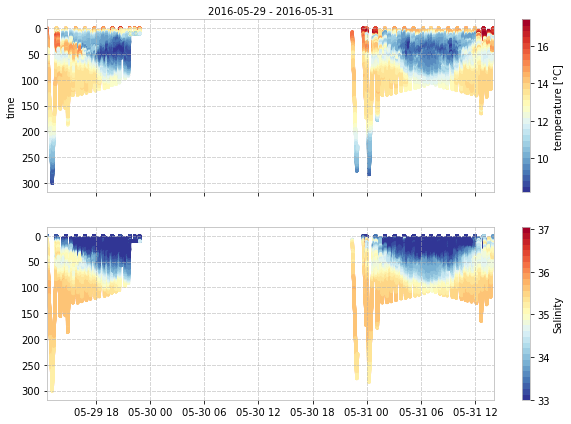

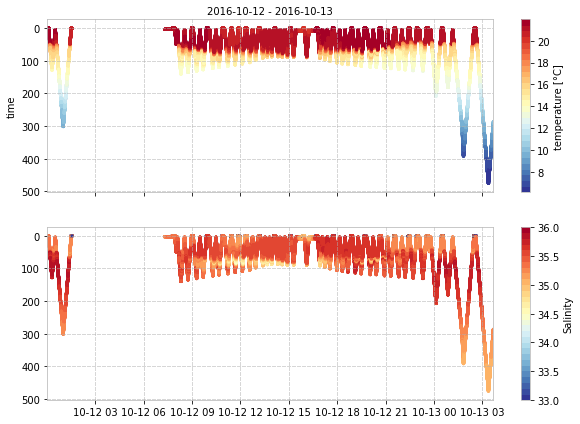

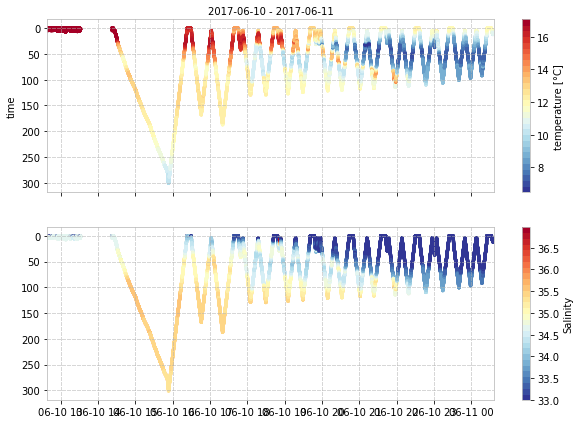

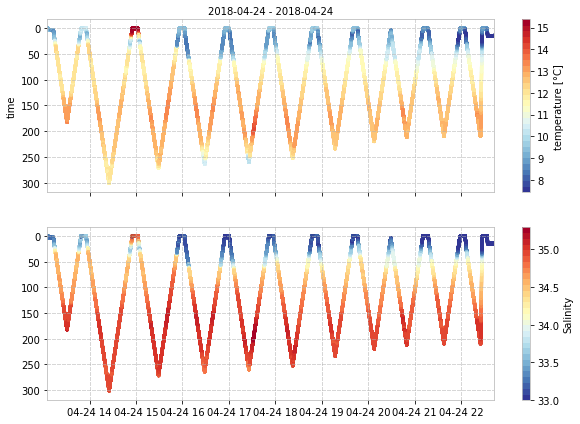

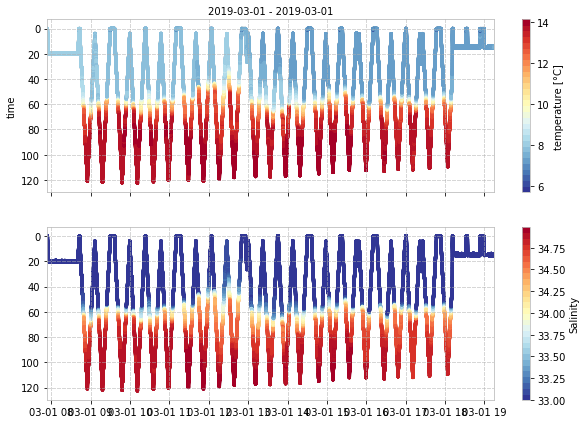

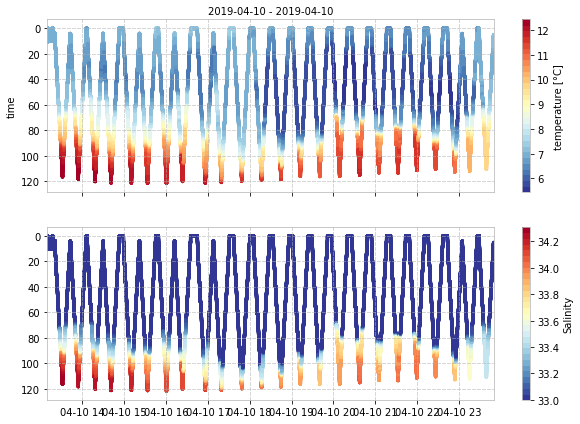

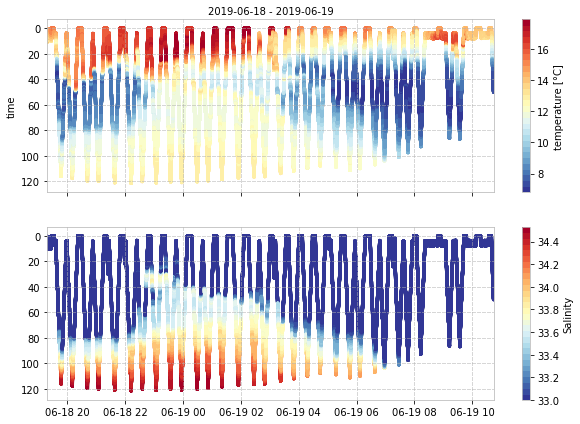

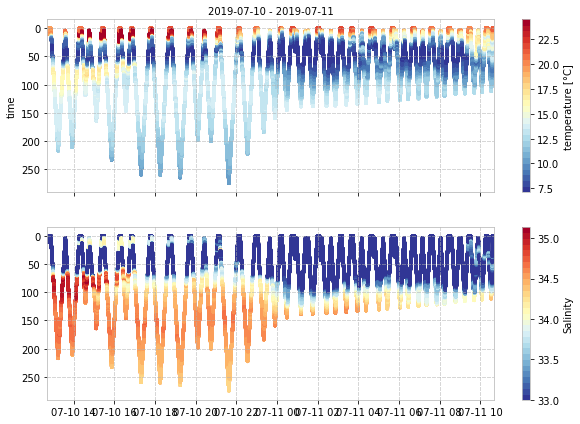

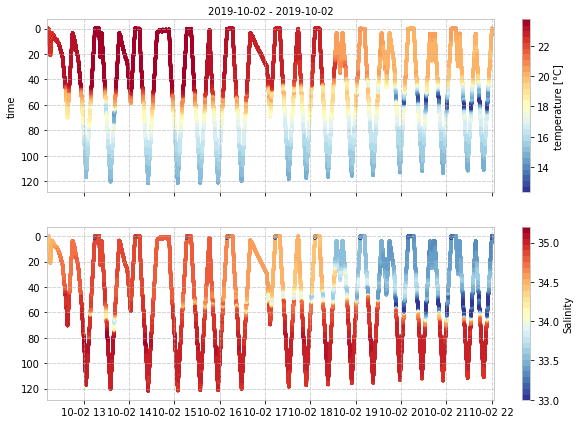

In [50]:
# plot profiles (up- and downcast) as scatter plot
for n in range(len(deployments)):
    ds=deployments[n]

    fig,ax = plt.subplots(figsize=(10,7),nrows=2,sharex=True,sharey=True)
    c = ax[0].scatter(ds.time.values,ds.m_depth,s=5,
                        c=ds.temperature,
                        cmap = plt.get_cmap('RdYlBu_r',30))
    c2 = ax[1].scatter(ds.time.values,ds.m_depth,s=5,
                        c=ds.salinity,
                        cmap = plt.get_cmap('RdYlBu_r',30),vmin=33)
    ax[0].set_xlim(ds.time[0].values,ds.time[-1].values)
    ax[0].invert_yaxis()
    ax[0].set_ylabel('depth [m]')
    ax[0].set_ylabel('time')
    ax[0].set_title(str(ds.time[0].values)[0:10] + ' - ' + str(ds.time[-1].values)[0:10])

    plt.colorbar(c,ax=ax[0],label='temperature [\N{DEGREE SIGN}C]')
    plt.colorbar(c2,ax=ax[1],label='Salinity')
    plt.savefig('./remus2_mission_' + str(n) + '_tem_sal_scatter.jpg',dpi=300)

In [85]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    from datetime import timedelta
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

datenum_to_datetime(mdates.date2num()[0]).strftime('%b %Y')

'May 2015'

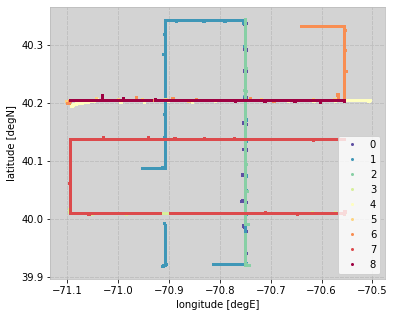

In [123]:
fig,ax = plt.subplots(figsize=(6,5))#,subplot_kw = dict(projection=proj))
cols=plt.get_cmap('Spectral_r',9)
# add lat,lon from section
for n in range(len(deployments)):
    ds1 = deployments[n]
    ax.plot(ds1.auv_longitude,ds1.auv_latitude,marker='.',linestyle='None',color=cols(n),label=str(n))
plt.legend()
ax.set_facecolor('lightgray')
ax.set_xlabel('longitude [degE]')
ax.set_ylabel('latitude [degN]')
plt.savefig('./remus_map_all_missions.jpg',dpi=300)

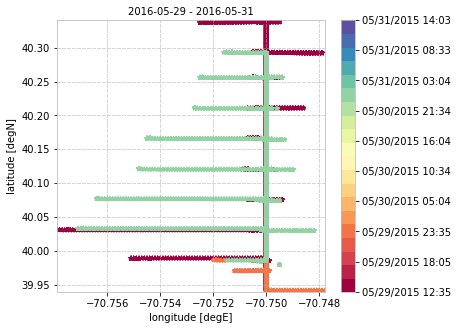

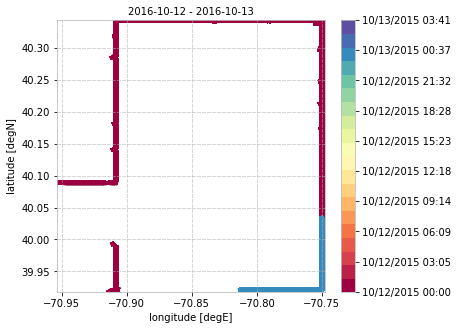

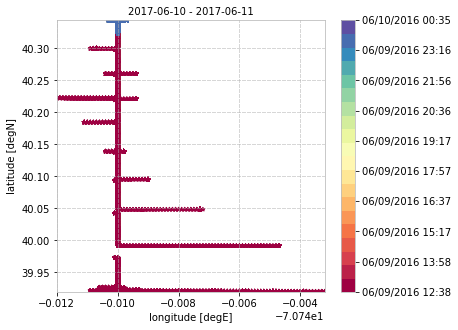

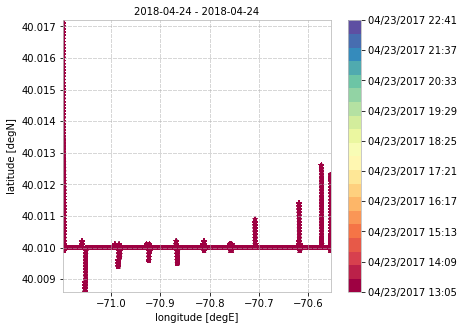

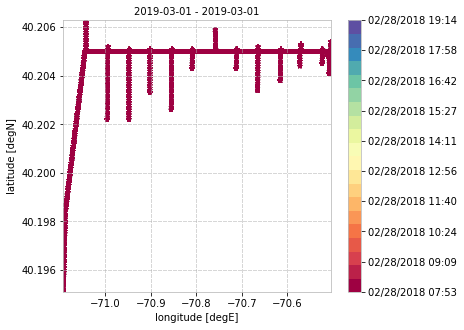

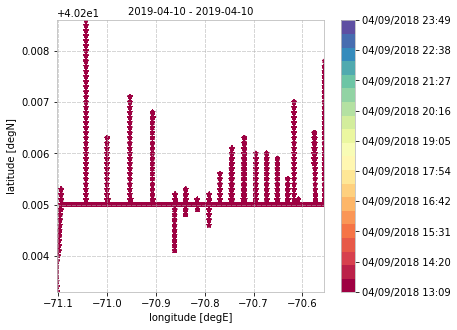

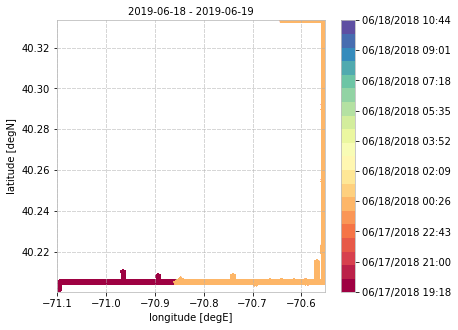

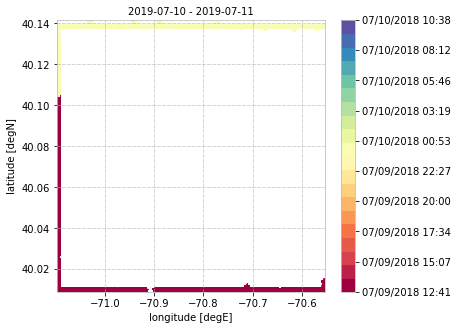

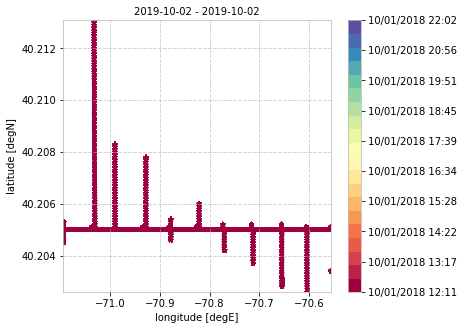

In [115]:
# plot map of positions
for n in range(len(deployments)):
    ds1 = deployments[n]
    datenum = mdates.date2num(ds1['time'].values)
    ticks = np.linspace(datenum[0],datenum[-1],10)

    # define projection
    proj = ccrs.PlateCarree()

    fig,ax = plt.subplots(figsize=(6,5))#,subplot_kw = dict(projection=proj))

    # add lat,lon from section
    cc=ax.scatter(ds1.auv_longitude,ds1.auv_latitude,c=datenum.astype(int),
               marker='*',linestyle='None',cmap=plt.get_cmap('Spectral',20),vmin=datenum[0],vmax=datenum[-1])
    cb = plt.colorbar(cc,ticks=ticks)
    cb.ax.set_yticklabels([datenum_to_datetime(index).strftime('%m/%d/%Y %H:%M') for index in ticks]);

    ax.set_xlim(np.min(ds1.auv_longitude.values),np.max(ds1.auv_longitude.values));
    ax.set_ylim(np.min(ds1.auv_latitude.values),np.max(ds1.auv_latitude.values));
    
    ax.set_title(str(ds1.time[0].values)[0:10] + ' - ' + str(ds1.time[-1].values)[0:10])
    ax.set_xlabel('longitude [degE]')
    ax.set_ylabel('latitude [degN]')
    plt.savefig('./remus_mission_' + str(n) + '_map.jpg',dpi=300)

In future it would be nice to add bathymetry to the map 

# Possible future steps  

- plot scatter plots for all different deployments
- plot individual profiles (need to separate profiles)
- see https://github.com/sryan288/ohw20-proj-ooi-profiles-section/blob/master/01_OOI_Profiles_Svenja.ipynb for some examples of what to do with profiling data.